In [23]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [24]:
import os
import cv2
import time
import uuid

In [25]:
IMAGES_PATH=os.path.join('data','images')
number_images=30

In [28]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
     print('Collecting image {}'.format(imgnum))
     ret, frame = cap.read()
     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
     cv2.imwrite(imgname, frame)
     cv2.imshow('frame', frame)
     time.sleep(0.5)
    
     if cv2.waitKey(1) & 0xFF == ord('q'):
      break
       
cap.release()
cv2.destroyAllWindows() 

In [31]:
!labelme

2024-03-09 17:23:19,110 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\sweta\.labelmerc


In [32]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [33]:
tf.test.is_gpu_available()

False

In [34]:
images= tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

In [35]:
images.as_numpy_iterator().next() #This is done to check if the file paths is stored

b'data\\images\\18ec6d82-de0b-11ee-99cf-e93b5bd5ab8a.jpg'

In [36]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img 

In [37]:
images = images.map(load_image)

In [38]:
images.as_numpy_iterator().next()

array([[[26, 23, 14],
        [27, 24, 15],
        [27, 24, 15],
        ...,
        [32, 28, 17],
        [34, 27, 17],
        [34, 27, 17]],

       [[27, 24, 15],
        [27, 24, 15],
        [27, 24, 15],
        ...,
        [31, 27, 16],
        [33, 26, 16],
        [32, 25, 15]],

       [[28, 25, 16],
        [28, 25, 16],
        [28, 25, 18],
        ...,
        [30, 26, 17],
        [31, 24, 16],
        [30, 23, 15]],

       ...,

       [[ 5,  5,  3],
        [ 5,  5,  3],
        [ 5,  6,  1],
        ...,
        [21,  6,  3],
        [21,  6,  3],
        [21,  6,  3]],

       [[ 6,  6,  4],
        [ 6,  6,  4],
        [ 6,  6,  4],
        ...,
        [21,  5,  5],
        [20,  6,  5],
        [20,  6,  5]],

       [[ 6,  6,  4],
        [ 6,  6,  4],
        [ 6,  6,  4],
        ...,
        [21,  5,  5],
        [20,  6,  5],
        [20,  6,  5]]], dtype=uint8)

In [39]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [40]:
image_generator = images.batch(4).as_numpy_iterator()

In [41]:
plot_images = image_generator.next()

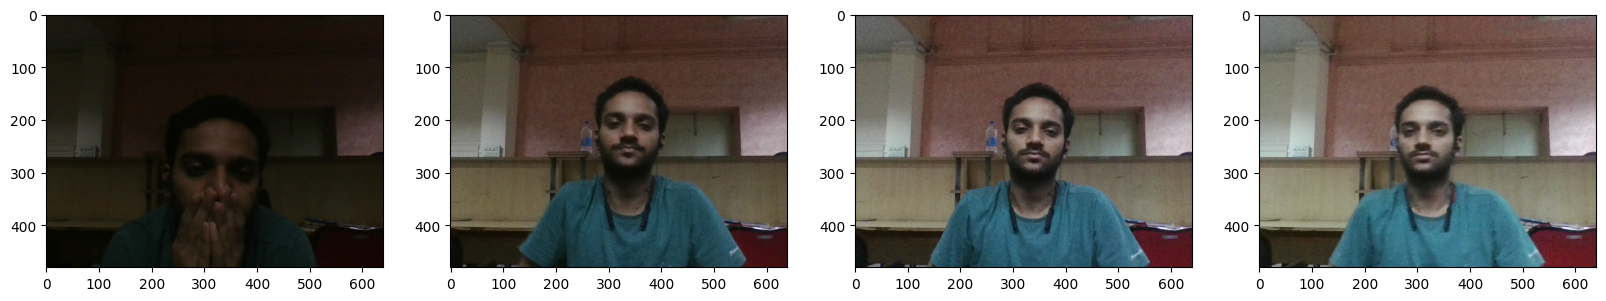

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20),)
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# Now we have data, we have loaded it in model variables and now we have to do 
# train, test split but here we do it manually by making folders and cut and paste. Putting 70% in train and 15% each in test and val on random basis

In [43]:
#Moving the matching labels.
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename=file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels',filename)
            os.replace(existing_filepath, new_filepath) 

In [44]:
import albumentations as alb

In [56]:
img = cv2.imread(os.path.join('data','train','images','1a018ce1-de0b-11ee-b2a7-e93b5bd5ab8a.jpeg'))

In [58]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                             alb.HorizontalFlip(p=0.5), 
                             alb.RandomBrightnessContrast(p=0.2),
                             alb.RandomGamma(p=0.2), 
                             alb.RGBShift(p=0.2), 
                             alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels']))

In [59]:
img = cv2.imread(os.path.join('data','train','images','84cb5b1b-ddcd-11ee-99d2-c30c817b9ee4.jpg'))

In [61]:
with open(os.path.join('data', 'train', 'labels', '1a018ce1-de0b-11ee-b2a7-e93b5bd5ab8a.json'), 'r') as f:
       label = json.load(f)

In [62]:
label['shapes'][0]['points']

[[246.16279069767438, 136.80232558139537],
 [398.48837209302326, 309.4767441860465]]

In [63]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [64]:
coords #pascal_voc format of coordiinates

[246.16279069767438, 136.80232558139537, 398.48837209302326, 309.4767441860465]

In [65]:
coords = list(np.divide(coords, [640,480,640,480])) #albumentation format of coordinates 

In [66]:
coords

[0.3846293604651162,
 0.28500484496124034,
 0.6226380813953488,
 0.6447432170542636]

In [68]:
image_np = np.array(image)  # This was done because augmentor wanted input n numpy format
augmented = augmentor(image=image_np, bboxes=[coords], class_labels=['face'])

In [69]:
augmented['bboxes']

[(0.5248062015503875,
  0.24622739018087858,
  0.8633074935400517,
  0.6299483204134367)]

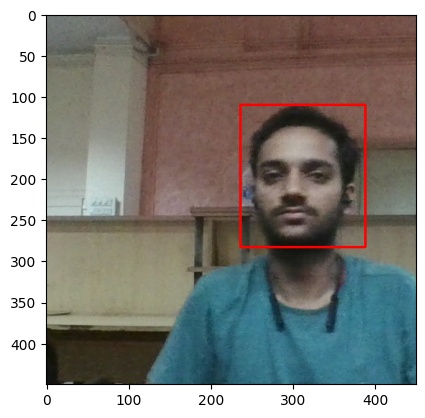

In [70]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                        (255,0,0), 2)
    
plt.imshow(augmented['image'])

In [73]:
for partition in ['train','test','val']:
        for image in os.listdir(os.path.join('data', partition, 'images')):
            img = cv2.imread(os.path.join('data', partition, 'images', image))
    
            coords = [0,0,0.00001,0.00001]
            label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)

                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [640,480,640,480]))
    
            try: 
                for x in range(60):
                    augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                    cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
    
                    annotation = {}
                    annotation['image'] = image
    
                    if os.path.exists(label_path):
                        if len(augmented['bboxes']) == 0: 
                            annotation['bbox'] = [0,0,0,0]
                            annotation['class'] = 0 
                        else: 
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class'] = 1
                    else: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
    
    
                    with open(os.path.join('aug_data', partition, 'labels', f'{image.split()[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)
    
            except Exception as e:
                print(e)

x_max is less than or equal to x_min for bbox [0.3419331395348837, 0.8615552325581395, 0.0, 0.11092628244462178, 'face'].
x_max is less than or equal to x_min for bbox [0.2556322674418604, 0.8567102713178295, 0.0, 0.15884862370253583, 'face'].
x_max is less than or equal to x_min for bbox [0.2401889534883721, 0.6968265503875969, 0.003997093023255793, 0.21111918604651164, 'face'].
x_max is less than or equal to x_min for bbox [0.18386627906976738, 0.5333091085271319, 0.0, 0.9124975095993623, 'face'].


In [74]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [75]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [76]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [77]:
train_images.as_numpy_iterator().next()

array([[[0.06960785, 0.11666667, 0.10882353],
        [0.07450981, 0.12156863, 0.11335784],
        [0.08186275, 0.12892157, 0.12107843],
        ...,
        [0.10618872, 0.03560049, 0.02775735],
        [0.10765931, 0.03707108, 0.0223652 ],
        [0.10343137, 0.04019608, 0.02512255]],

       [[0.07824755, 0.12138481, 0.10569853],
        [0.08284314, 0.12506127, 0.11213236],
        [0.08235294, 0.12156863, 0.11764706],
        ...,
        [0.10490196, 0.03578432, 0.02745098],
        [0.10104167, 0.04307598, 0.02218137],
        [0.10490196, 0.04215686, 0.01452206]],

       [[0.08118872, 0.1264706 , 0.11078431],
        [0.08627451, 0.1254902 , 0.12156863],
        [0.07064951, 0.11770833, 0.1098652 ],
        ...,
        [0.09754902, 0.03872549, 0.02696078],
        [0.090625  , 0.03964461, 0.0161152 ],
        [0.09117647, 0.04460784, 0.01666667]],

       ...,

       [[0.09166667, 0.07843138, 0.04019608],
        [0.09803922, 0.08235294, 0.03921569],
        [0.0911152 , 0

In [78]:
def load_labels(label_path):
        with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
            label = json.load(f)
            
        return [label['class']], label['bbox']

In [79]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [80]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [81]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [82]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1718, 0.0858, 0.668 , 0.6787], dtype=float16))

In [83]:
len(train_images),len(test_images),len(val_images),len(train_labels),len(test_labels),len(val_labels)

(10920, 2400, 2460, 10920, 2400, 2460)

In [84]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [85]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [86]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [87]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [88]:
data_samples = train.as_numpy_iterator()

In [89]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


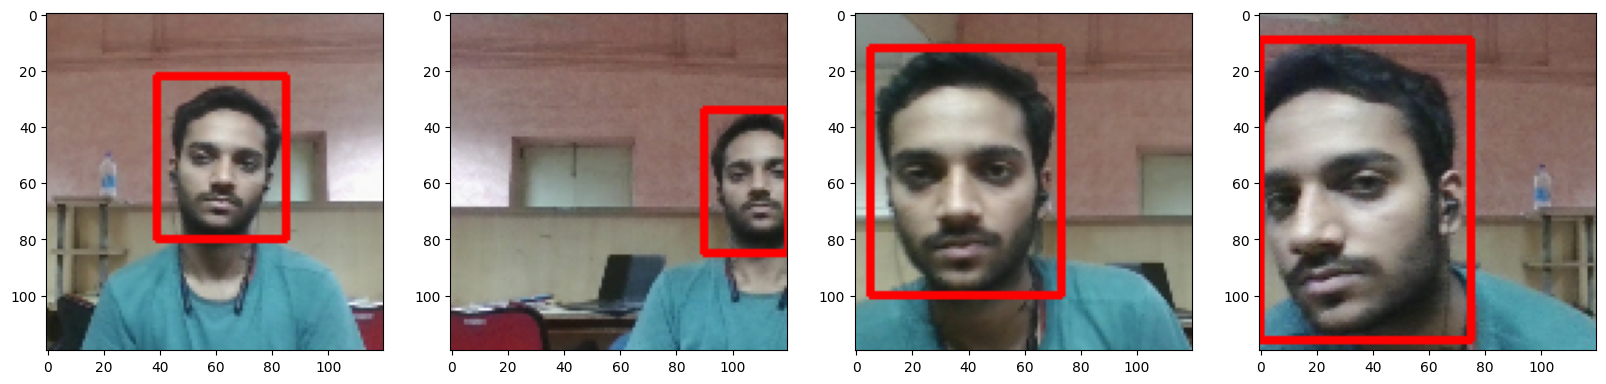

In [90]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_image_cv2 = cv2.UMat(sample_image)
    cv2.rectangle(sample_image_cv2,
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)
    sample_image = sample_image_cv2.get()
    ax[idx].imshow(sample_image)

In [91]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [92]:
vgg = VGG16(include_top=False)

In [93]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [94]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
   
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [95]:
facetracker = build_model()

In [96]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [97]:
X, y = train.as_numpy_iterator().next()

In [98]:
X.shape

(8, 120, 120, 3)

In [99]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [100]:
classes, coords

(array([[0.40797114],
        [0.49944478],
        [0.5935341 ],
        [0.5846426 ],
        [0.63853586],
        [0.47705674],
        [0.5654122 ],
        [0.47962824]], dtype=float32),
 array([[0.62035924, 0.25676152, 0.50403845, 0.36198354],
        [0.58482045, 0.23635097, 0.5413261 , 0.3793056 ],
        [0.6719702 , 0.18627447, 0.39396092, 0.33539477],
        [0.5848453 , 0.28159124, 0.45349583, 0.40158945],
        [0.66655314, 0.3528226 , 0.4250403 , 0.37441963],
        [0.58021677, 0.20161833, 0.52062774, 0.28693393],
        [0.62989503, 0.17106427, 0.5827673 , 0.34740636],
        [0.73389554, 0.2517004 , 0.5420271 , 0.38751298]], dtype=float32))

In [101]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [102]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [103]:
 def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 
    
    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [104]:
 classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [105]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.2656927>

In [106]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.64285904>

In [107]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.2656927>

In [108]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker
    
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
            
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
               
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
    
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
        
        
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [109]:
model = FaceTracker(facetracker)

In [110]:
model.compile(opt, classloss, regressloss)

In [111]:
logdir='logs'

In [112]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

 826/1365 [=================>............] - ETA: 58:37 - total_loss: 0.1969 - class_loss: 0.0392 - regress_loss: 0.1773

In [114]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
    
    ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
    ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
    ax[0].title.set_text('Loss')
    ax[0].legend()
    
    ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
    ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
    ax[1].title.set_text('Classification Loss')
    ax[1].legend()
    
    ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
    ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
    ax[2].title.set_text('Regression Loss')
    ax[2].legend()
    
    plt.show()

IndentationError: unexpected indent (1779861617.py, line 3)

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                          tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                                (255,0,0), 2)
    
        ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()